## Clase 03: Trabajando con los metadatos de la imagen

------


### Objetivos de esta Notebook:

En esta Notebook vamos a trabajar con los metadatos que vienen asociados a nuestra imagen SPOT, como excusa para aprender a interpretar y extraer los parámetros de archivo XML, y usarlos en operaciones con nuestras bandas. A este tipo de operaciones se le suele llamar _parsing_ en inglés, o simplemente _parseo_ en español.

Los objetivos que cubriremos serán:

1) Entender cómo está estructurado un XML y de qué manera se accede a sus elementos desde Python.  
2) Extraer parámetros y constantes del XML asociado a nuestras imágenes, que contiene sus metadatos.  
3) Utilizar los parámetros extraidos para realizar correcciones radiométricas sobre nuestras imágenes.

### 1) Los archivos XML

XML quiere decir _Extensible Markup Language_ , que se podría traducir como Lenguaje de Marcas Extensibles; lo cual, si no conocemos de antes este tipo de archivos, no nos dice mucho.

Los archivos XML se componen de etiquetas o marcadores que nos aportan información de distinto tipo. Estas etiquetas o marcadores a su vez pueden estar anidados en varios niveles, dando una idea de jerarquía. Esto es muy util a la hora de organizar y compartir la información.

Un ejemplo muy simple de estructura XML sería la siguiente:
```xml
<?xml version="1.0" encoding="UTF-8"?>
   <note>
       <to>Tove</to>
       <from>Jani</from>
       <heading>Reminder</heading>
       <body>Don't forget me this weekend!</body>
   </note>
```

Al inicio de un archivo de este tipo casi siempre encontrarán una primera línea que en inglés se llama _prólogo_:
```xml
<?xml version="1.0" encoding="UTF-8"?>
```

En esta línea se especifica cuál es la versión de XML que se está usando, y cuál es la codificación de caracteres elegida. Esto es muy importante, sobre todo si dentro del contenido se hará uso de caracteres especiales.

Luego se desarrolla el contenido del archivo. Siempre debe existir un único elemento o nodo **raíz** que contiene a los demás. En este caso la raíz es la entrada **note** y sus elementos _hijos_ son los atributos _to , from, heading, body_.

Todo elemento de un XML, ya sea un nodo raiz, sub-nodo o atributo simple, debe abrirse y cerrarse explícitamente. Para ello se usan los símbolos **<>** y **<\/>** respectivamente. En nuestro ejemplo, abrimos el nodo raíz con **```<note>```** y lo cerramos con **```</note>```**. De manera similar se hace con el resto de los atributos.

Más referencias sobre el uso y sintaxis de archivos XML se pueden consultar [aquí](https://www.w3schools.com/xml/xml_syntax.asp). Nosotros no nos dedicaremos a escribir archivos XML en esta clase, sino solo a leerlos.

Veamos cómo abrir y leer con Python un archivo XML simple; luego veremos cómo hacerlo con ejempos más complejos. En la carpeta _Data_ hemos dejado colgado un archivo que se llama **ejemplo_xml.xml**, que es el mismo del ejemplo mostrado en la celda anterior. Para esto utilizaremos la librería _xml_.

**Tip**: Algunos editores de texto avanzados como [Notepad++](https://notepad-plus-plus.org/downloads/) permiten abrir los archivos XML y expandir/contraer los nodos para ver más claramente cómo es la estructura y jerarquía del documento.

In [1]:
from xml.etree import ElementTree as ET

f = open('../Data/ejemplo_xml.xml')
tree =  ET.parse(f)
root =  tree.getroot()

#Siempre cerrar el archivo una vez que no lo usamos más
f.close()

print(root)

<Element 'note' at 0x7ff74c1bca90>


Ya tenemos a la raiz del XML "capturada" en una variable que hemos llamado _root_. No es exactamento un texto: por eso cuando imprimimos su contenido nos devuelve ```<Element 'note' at 0x7fda0804b6d0>```. Para desmenuzarla un poco más debemos operar con el código:

In [2]:
for item in root:
    print(item.text)

Tove
Jani
Reminder
Don't forget me this weekend!


Con _.text_ obtenemos como texto el contenido de cada uno de los nodos hijo. Como sabemos que cada uno de ellos no tiene sub-nodos, obtendremos directamente el contenido del atributo. No obstante, pensando en estructuras más anidadas, podríamos identificarlos por su etiqueta y guardar cada uno a una variable para luego trabajar con ellas:

In [3]:
to = root.findall('to')

for item in to:
    to_text = item.text
    
print(to_text)

# Alternativamente, podemos usar compresión de listas:

to_text = [item.text for item in to]

print(to_text[0])

Tove
Tove


En la celda anterior usamos dos métodos distintos para extraer el contenido del nodo _to_: Uno usando un ciclo for y guardando el contenido como texto en la variable **to_text**; y el otro usando compresión de listas y devolviendo una lista que, en este caso, tiene un solo elemento ('Tove', el elemento 0). Utilizar la compresión de listas nos servirá mucho para ahorrar líneas de código cuando trabajemos con archivos XML más grandes, pero debe quedar claro que ambas vías nos permiten llegar a lo mismo. 

#### Ejercicio 1.1:

Al igual que lo hicimos con el atributo _to_, extraer (como lista o como texto) el resto de los atributos del XML de ejemplo con el que venimos trabajando.

### 2) Trabajando con los metadatos para calibrar la imagen SPOT

Antes de comenzar a leer los metadatos de nuestra SPOT, repasaremos un poco el significado de realizar calibraciones en [esta presentación](https://drive.google.com/file/d/1WdLFSqtsw534waCD6FsRY8zAuEXz6T15/view?usp=sharing).

En esta sección nosotros buscaremos llegar a dos magnitudes que nos interesan para poder calibrar nuestra SPOT:

1) La radiancia, que con los metadatos de las SPOT la calculamos como:

$\large L = \frac{DN}{gain} + bias$

2) La reflectancia a tope de la atmósfera, que la calculamos como:

$\large p_{TOA} = \frac{L \pi d^2}{E_0 cos \theta}$

Estas son magnitudes que deberemos calcular para cada una de las bandas de la SPOT. Seguiremos trabajando con la imagen multiespectral que venimos usando, y con su archivo de metadatos que también está en la carpeta Data:```DIM_SPOT7_MS_201708061354452_ORT_C0000000072330.XML```

#### 2.1 Cálculo de la radiancia

Para obtener la radiancia necesitamos encontrar los factores aditivos y multiplicativos para cada banda (el BIAS y el GAIN). Si abrimos el XML con Notepad++ u otro editor de texto, vamos a ver que esta información está dentro del nodo **Radiometric_Data**, que a su vez contiene muchos sub-nodos más:

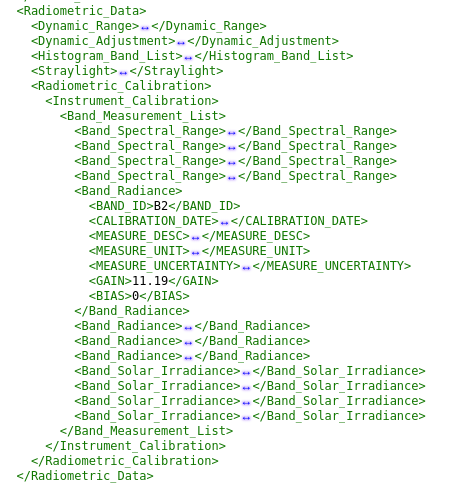

Si exploramos la jerarquía de este nodo, el orden sería: **Radiometric_Data --> Radiometric_Calibration --> Instrument_Calibration --> Band_Measurement_List --> Band_Radiance**. Veremos además que hay 4 nodos que se llaman Band_Radiance, uno por cada banda, y que en cada uno de ellos están los valores de GAIN y BIAS que buscamos. 

En las siguientes celdas buscaremos extraer listas de valores de GAIN y BIAS, y luego nos preocuparemos por entender a qué banda corresponde cada uno de ellos.

In [4]:
#Primero: Leemos el archivo XML con los metadatos de la SPOT

f = open('../Data/DIM_SPOT7_MS_201708061354452_ORT_C0000000072330.XML')
tree =  ET.parse(f)
root =  tree.getroot()

#Siempre cerrar el archivo una vez que no lo usamos más
f.close()

In [5]:
#Localizamos el nodo Radiometric_Data:

radiometric_data = root.findall('Radiometric_Data')

# Localizamos el sub-nodo Radiometric_Calibration:

radiometric_calibration = [item.findall('Radiometric_Calibration') for item in radiometric_data][0]

**Nota:** Detengámosnos por un segundo en la celda anterior: Para ubicar el sub-nodo Radiometric_calibration usamos compresión de listas, lo cual nos devuelve una lista, de un solo elemento. Como nos interesa trabajar con el contenido de esa lista, agregamos el ``[0]`` al final.

In [6]:
# Localizamos el sub-nodo Instrument_Calibration:
instrument_calibration = [item.findall('Instrument_Calibration') for item in radiometric_calibration][0]

# Localizamos el sub-nodo Band_Measurement_List:
band_measurement_list = [item.findall('Band_Measurement_List') for item in instrument_calibration][0]

# Localizamos el sub-nodo Band_Radiance:
band_radiance = [item.findall('Band_Radiance') for item in band_measurement_list][0]

#Finalmente, construimos nuestras listas de GAIN y BIAS mirando la información de cada nodo Band_Radiance:

gain = [item.find('GAIN').text for item in band_radiance]
bias = [item.find('BIAS').text for item in band_radiance]

print(gain)
print(bias)

['11.19', '10.28', '9.02', '16.93']
['0', '0', '0', '0']


¡Muy bien! Ya hemos logrado llegar a los valores que buscábamos. Ahora bien ¿a qué banda corresponde cada uno? Si nos fijamos bien, dentro de cada bloque Band_Radiancia hay una entrada que se llama BAND_ID. Aprovechemos que hemos parseado el XML hasta este nivel e imprimamos las listas de BAND_ID:

In [7]:
band_id = [item.find('BAND_ID').text for item in band_radiance]

print(band_id)

['B2', 'B1', 'B0', 'B3']


Lo anterior nos indica que el primer GAIN/BIAS que extrajimos corresponde a B2, el siguiente par a B1 y así con los otros dos. Este orden de numeración es un poco extraño ¿no?.

Si nos vamos un poco más arriba en el XML vamos a encontrar un nodo que se llama **Raster_Display** que nos va a ayudar a entender un poco mejor esto:

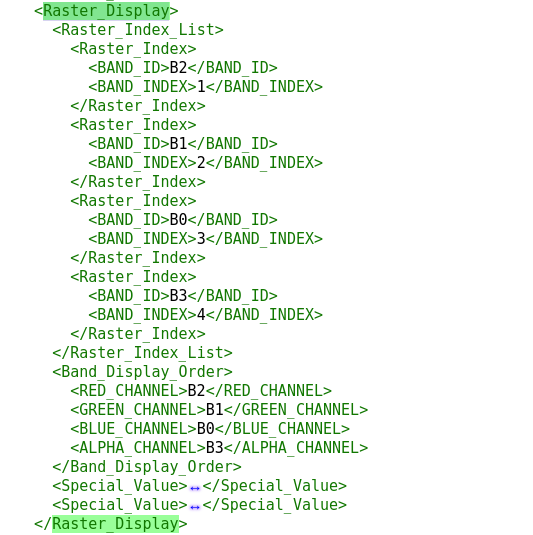

Si miramos esta información, nos dice que B2 corresponde al Rojo, B1 al Verde, B0 al Azul y B3 al Infrarrojo Cercano, y que ocupan las posiciones 1,2,3 y 4 respectivamente (un poco complicadas estas nomenclaturas!), lo cual efectivamente se corresponde con lo que vimos en la Notebook anterior, donde por ejemplo con la combinación de bandas 1-2-3 obteníamos el Color Natural.

Ahora que tenemos más claro el orden de las bandas, trabajemos por ejemplo con la banda roja (la primera) para calcular su radiancia. Tenemos que aplicarlos sobre cada uno de los píxeles de nuestra banda, que están en contaje digital. Por lo tanto, debemos primero abrir nuestro raster **SPOT_20170806_MS.tif**:

In [8]:
import gdal

spot_apilada = gdal.Open('../Data/SPOT_20170806_MS.tif')
gt = spot_apilada.GetGeoTransform()
src = spot_apilada.GetProjection()

spot_apilada = spot_apilada.ReadAsArray()
red_band = spot_apilada[0,:,:]

In [9]:
#Leemos los factores aditivos y multiplicativos de la banda roja:
gain_red = float(gain[0])
bias_red = float(bias[0])

In [10]:
#Calculamos la radiancia:

red_L = red_band / gain_red + bias_red

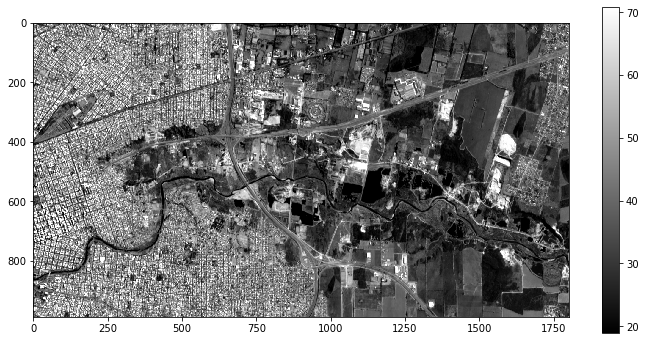

In [34]:
#Visualizamos la nueva capa de radiancia para ver si se hizo bien la operación:

from matplotlib import pyplot as plt
import numpy as np

plt.figure(figsize = (12,6))
plt.imshow(red_L, cmap = 'gray', vmin = np.percentile(red_L, 2), vmax = np.percentile(red_L, 98))
plt.colorbar()
plt.show()

El resultado parece tener sentido. ¡Al menos no tenemos una matriz con todos 0 o Nan!
Ahora la guardamos como GeoTiff, para poder utilizarla por afuera de Python. Reutilizamos celdas de la Notebook anterior, solo que ahora guardaremos un dato de tiplo **flotante**.

In [12]:
driver = gdal.GetDriverByName('GTiff')
filas = spot_apilada.shape[1]
columnas = spot_apilada.shape[2]

bandas = 1 
imagen_salida = driver.Create('SPOT_20170806_MS_R_L.tif', columnas, filas, bandas, gdal.GDT_Float32)
imagen_salida.SetProjection(src)
imagen_salida.SetGeoTransform(gt)
imagen_salida.GetRasterBand(1).WriteArray(red_L)
del imagen_salida

#### Ejercicio 2.1

1) Repetir el procedimiento realizado con la banda roja para obtener la radiancia del resto de las bandas. 

2) Guardar los resultados a Geotiff. Pueden guardar uno separado para cada banda, o un apilado con las 4 radiancias.

#### Cálculo de la reflectancia:

Para poder llegar a la reflectancia tenemos que usar la radiancia y además encontrar o calcular los siguientes parámetros en los metadatos:

- La distancia Tierra-Sol, que la podemos calcular con la fecha de la imagen.
- El ángulo de elevación solar, que está en los metadatos.
- La irradiancia solar o exoatmosférica para cada banda, que se puede extraer también de los metadatos.

Comencemos por la distancia Tierra-Sol:
 
$d = 1 - 0.0167 cos(\frac{2\pi (DOY-3)}{365})$

El _DOY_ es el dia juliano del año de la adquisición de la imagen, pero generalmente en los metadatos esta fecha suele venir en formato gregoriano. Esta información la podemos encontrar en el XML como **IMAGING_DATE** y está ne Dataset_Sources --> Source_Identification --> Strip_Source --> IMAGING_DATE:

In [14]:
#Localizamos Dataset_Sources:
dataset_sources = root.findall('Dataset_Sources')

#Localizamos Source_Identification:
source_identification = [item.findall('Source_Identification') for item in dataset_sources][0]

#Localizamos Strip_Source:
strip_source = [item.findall('Strip_Source') for item in source_identification][0]

#Localizamos IMAGING_DATE
imaging_date = [item.find('IMAGING_DATE').text for item in strip_source][0]

print(imaging_date)

2017-08-06


La variable imaging_date es una cadena de texto. Para calcular el día juliano vamos a tener que interpretarla primero como fecha. Para ellos utilizaremos la librería **datetime**:

In [19]:
from datetime import datetime

dt = datetime.strptime(imaging_date,'%Y-%m-%d')
dt

datetime.datetime(2017, 8, 6, 0, 0)

Ahora ya tenemos un objeto "datetime". Con el método _strftime()_ podemos llegar a una cadena que represente el día juliano:

In [20]:
day = dt.strftime('%j')
day

'218'

**Nota:** Si te interesa conocer más sobre el manejo de fechas en Python, podés consultar el material del [curso de Python de UNSAM](https://github.com/python-unsam/Programacion_en_Python_UNSAM/blob/master/Notas/08_Fechas_Carpetas_y_Pandas/02_Fechas.md) que habla sobre este tema.

Ahora que tenemos el DOY, podemos calcular la distancia Tierra-Sol:

In [22]:
earth_sun_d = 1-0.0167*np.cos(2*np.pi*(int(day)-3)/365)
earth_sun_d

1.0141539334123102

Sigamos con el ángulo de elevación solar. Dentro del XML lo podemos encontrar en el nodo **SUN_ELEVATION** que está a su vez en Geometric_Data --> Use_Area --> Located_Geometric_Values --> Solar_Incidences:

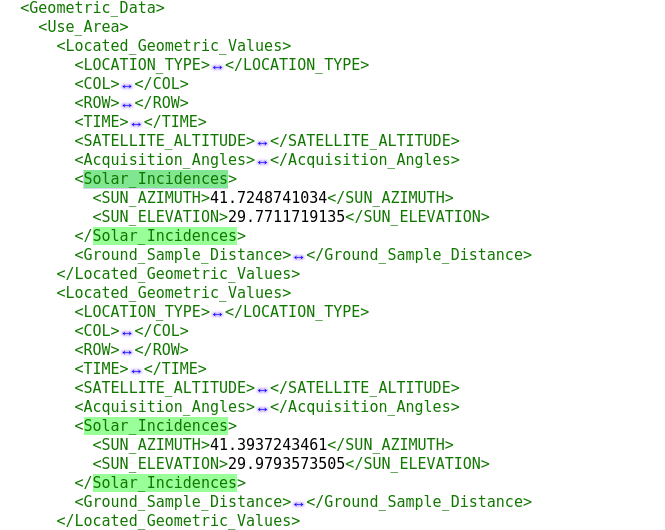

Si navegamos por todo el documento vamos a ver que hay varios valores o muestras del ángulo de elevación solar. Esto es porque a medida que el satélite se mueve, el mismo va varando un poco, por lo que hay mediciones del mismo en distintos puntos de la trayectoria de la SPOT. Sin embargo nosotros no nos vamos a complicar mucho con esto: Vamos a extraer todos los valores de SUN_ELEVATION disponibles y luego sacar una media.

In [24]:
#Localizamos Geometric_Data:
geometric_data = root.findall('Geometric_Data')

#Localizamos Use_Area:
use_area = [item.findall('Use_Area') for item in geometric_data][0]

#Localizamos Located_Geometric_Values
located_geometric_values = [item.findall('Located_Geometric_Values') for item in use_area][0]

#Localizamos Solar_Incidences
solar_incidences = [item.find('Solar_Incidences') for item in located_geometric_values]

#Localizamos SUN_ELEVATION
sun_elevation = [float(item.find('SUN_ELEVATION').text) for item in solar_incidences]

sun_elevation

[29.7711719135,
 29.9793573505,
 30.1881489007,
 29.3850816857,
 29.5922861222,
 29.8001256573,
 28.9990175115,
 29.2053060176,
 29.4122580226]

In [26]:
#Calculamos el ángulo de elevación solar promedio:
mean_sun_elevation = np.mean(sun_elevation)
mean_sun_elevation

29.592528131288887

Por último nos queda la irradiancia solar o exoatmosférica para cada banda ($E_{0}$). Por suerte estos parámetros están en la misma sección que el GAIN y BIAS que buscamos para calcular la radiancia, específicamente dentro de **Band_Measurement_List**, identificado como **Band_Solar_Irradiance**. Al igual que con el GAIN y el BIAS, tenemos un valor de $E_{0}$ para cada banda. **Band_Solar_Irradiance** tiene varias entradas o atributos; en particular a nosotros nos interesa rescatar la entrada **VALUE** que tiene el valor de $E_{0}$.

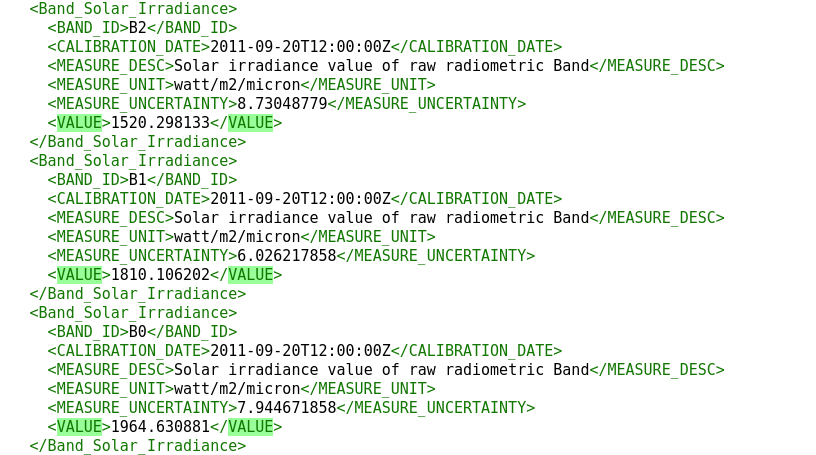

In [27]:
#Localizamos Band_Solar_Irradiance
band_solar_irradiance = [item.findall('Band_Solar_Irradiance') for item in band_measurement_list][0]

#Localizamos las entradas 'VALUE' dentro de Band_Solar_Irradiance
e0 = [float(item.find('VALUE').text) for item in band_solar_irradiance]

e0

[1520.298133, 1810.106202, 1964.630881, 1084.46188]

Ya sabemos a qué banda corresponde cada uno de estos $E_{0}$, nosotros trabajaremos solo con el de la banda roja, y dejaremos el resto para el ejercicio:

In [30]:
e0_red = e0[0]

Ahora si, podemos calcular la reflectancia!

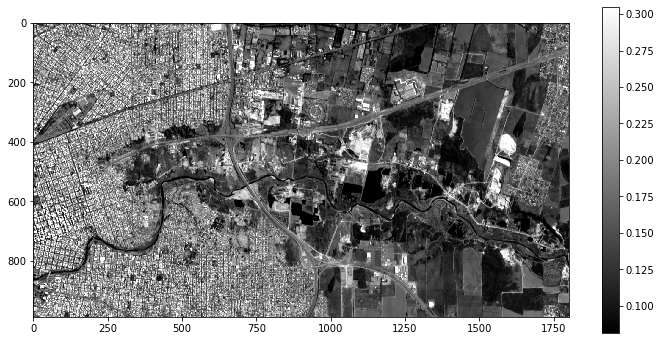

In [33]:
#Calculamos la reflectancia para la banda roja
# Atención: Cuando usamos la función seno o coseno, el ángulo debe estar expresado en radianes

red_p = (np.pi*red_L*(earth_sun_d)**2)/(e0_red*np.sin(mean_sun_elevation*np.pi/180))

#Visualizamos la nueva capa de reflectancia para ver si se hizo bien la operación:

from matplotlib import pyplot as plt
import numpy as np

plt.figure(figsize = (12,6))
plt.imshow(red_p, cmap = 'gray', vmin = np.percentile(red_p, 2), vmax = np.percentile(red_p, 98))
plt.colorbar()
plt.show()


#### Ejercicio 2.2:

1) Calcular la reflectancia para el resto de las bandas.  
2) Guardar las 4 bandas en reflectancia apiladas en un único archivo, nombrarlo como **SPOT_20170806_MS_p.tif**. Prestar atención al tipo de dato con que debe ser almacenado este producto.  
3) **Opcional**: Replicar el proceso de calibración a reflectancia con la imagen SPOT pancromática. En este caso deberás trabajar con los archivos **SPOT_20170806_PAN.tif** y **DIM_SPOT7_P_201708061354452_ORT_C0000000072330.XML** respectivamente.